In [74]:
import warnings
warnings.filterwarnings('ignore')
import pickle
transformed_df = pickle.load(open("dataframe.p","r"))


In [75]:
default_class = transformed_df[transformed_df['loan_status'] ==  1]
non_default_class = transformed_df[transformed_df['loan_status'] ==  0]
non_default_class = non_default_class.sample(n= default_class.shape[0]) 
undersampled_df = default_class.append(non_default_class, ignore_index=True)
undersampled_df = undersampled_df.sample(frac=1)
undersampled_df.shape[0]

(13342, 98)
(13342, 98)


26684

In [76]:
import sklearn
from  sklearn.model_selection import train_test_split
X = undersampled_df.drop('loan_status', axis=1)
Y= undersampled_df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=1)


## Random Forest Classifier with undersampled dataset
#### I Used the Clustering algorithms for the data for which I replace NAN with the mean and checked the performance.
#### The performance doesn't vary much with the generated Data and is more or less the same as the Regression_NAN notebook results.

In [77]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.3, random_state=1)
model = RandomForestClassifier(n_estimators=90,max_depth=15,max_features=20)
features = model.fit(X_train, y_train)
predicted = model.predict(X_test)
# generate class probabilities
probs = model.predict_proba(X_test)
print "Accuray of Random Forest Classifier is = ", sklearn.metrics.accuracy_score(y_test, predicted)
print "Roc auc score = ", sklearn.metrics.roc_auc_score(y_test, predicted)
print "Confusion Matrix \n", sklearn.metrics.confusion_matrix(y_test, predicted)
print "Classification Report \n",sklearn.metrics.classification_report(y_test, predicted)
scores = cross_val_score(model, X, Y, cv = 5)
print "Cross validation score", scores.mean()



Accuray of Random Forest Classifier is =  0.694354234324
Roc auc score =  0.693946099907
Confusion Matrix 
[[2383 1603]
 [ 844 3176]]
Classification Report 
             precision    recall  f1-score   support

          0       0.74      0.60      0.66      3986
          1       0.66      0.79      0.72      4020

avg / total       0.70      0.69      0.69      8006

Cross validation score 0.702068673419


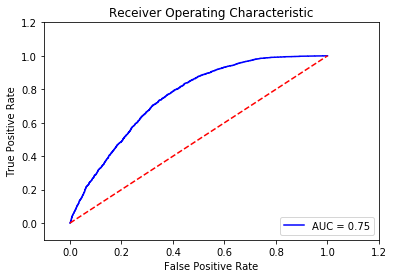

In [87]:
import matplotlib.pyplot as plt
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(y_test,probs[:,1])
roc_auc = sklearn.metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Logistic Regression with undersampled dataset

In [88]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1')
features = model.fit(X_train, y_train)
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)
print "Accuray of Logistic Regression Classifier is = ", sklearn.metrics.accuracy_score(y_test, predicted)
print "Roc auc score = ", sklearn.metrics.roc_auc_score(y_test, predicted)
print "Confusion Matrix \n", sklearn.metrics.confusion_matrix(y_test, predicted)
print "Classification Report \n",sklearn.metrics.classification_report(y_test, predicted)
scores = cross_val_score(model, X, Y, cv = 5)
print "Cross validation score", scores.mean()

Accuray of Logistic Regression Classifier is =  0.679115663253
Roc auc score =  0.679251509637
Confusion Matrix 
[[2835 1151]
 [1418 2602]]
Classification Report 
             precision    recall  f1-score   support

          0       0.67      0.71      0.69      3986
          1       0.69      0.65      0.67      4020

avg / total       0.68      0.68      0.68      8006

Cross validation score 0.683181081808


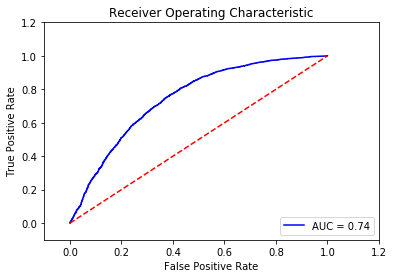

In [89]:
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(y_test,probs[:,1])
roc_auc = sklearn.metrics.auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Ensemble method after clustering non default class using kmeans clustering

### This was the experimentation section where I grouped the non_default class and took stratified representation from each cluster to down sample the data.

In [91]:
X = transformed_df.drop('loan_status', axis=1)
Y= transformed_df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=1)


#### Applying kmeans to non default class

In [92]:
from sklearn.cluster import KMeans
default_class = transformed_df[transformed_df['loan_status'] ==  1]
non_default_class = transformed_df[transformed_df['loan_status'] ==  0]
non_default_class = non_default_class.drop('loan_status',axis=1) 
kmeans = KMeans(n_clusters=10, random_state=0).fit(non_default_class)


#### Grouping non default class instances to its clusters

In [93]:
import numpy as np
non_default_class_dict = dict()
labels = kmeans.labels_
non_default_class = np.array(non_default_class)
for i in xrange(len(kmeans.labels_)):
    if labels[i] not in non_default_class_dict:
         non_default_class_dict[labels[i]] = []
    non_default_class_dict[labels[i]].append(non_default_class[i])
   

#### Combining default class instances with non default class instances to form different datasets

In [94]:
default_class = transformed_df[transformed_df['loan_status'] ==  1]
default_class = default_class.drop('loan_status',axis=1)
datasets = []
threshold = 3000
for label in non_default_class_dict:
    if len(non_default_class_dict[label]) > threshold:
        Y = [1 for i in xrange(default_class.shape[0])]
        Z = [0 for j in xrange(len(non_default_class_dict[label]))]
        Y.extend(Z)
        X = np.array(default_class)
        df2 = non_default_class_dict[label]
        X = np.concatenate((X,df2), axis=0)
        datasets.append((X,Y))

#### Fitting different logistic regression models

In [95]:
def final_predicted_values(model, threshold):
    predicted_values = []
    for i in xrange(num_of_datasets):
        predicted_values.append(model[i].predict(X_test))

    final_predicted = []
    for i in xrange(X_test.shape[0]):
        values = []
        for j in xrange(num_of_datasets):
            values.append(predicted_values[j][i])
        if values.count(1) > threshold:
            final_predicted.append(1)
        else:
            final_predicted.append(0)
    return final_predicted

In [96]:
num_of_datasets = 5
model = []
for i in xrange(num_of_datasets):
    model.append(LogisticRegression(class_weight='balanced',penalty='l1'))
    model[i].fit(datasets[i][0], datasets[i][1])

In [97]:
final_predicted = final_predicted_values(model,3)

In [98]:
print "Accuray of Ensemble Logistic Regression Classifier is = ", sklearn.metrics.accuracy_score(y_test, final_predicted)
print "Roc auc score = ", sklearn.metrics.roc_auc_score(y_test, final_predicted)
print "Confusion Matrix \n", sklearn.metrics.confusion_matrix(y_test, final_predicted)
print "Classification Report \n",sklearn.metrics.classification_report(y_test, final_predicted)

Accuray of Ensemble Logistic Regression Classifier is =  0.628631431572
Roc auc score =  0.664391377544
Confusion Matrix 
[[34924 21116]
 [ 1165  2792]]
Classification Report 
             precision    recall  f1-score   support

          0       0.97      0.62      0.76     56040
          1       0.12      0.71      0.20      3957

avg / total       0.91      0.63      0.72     59997



### Ensemble based Random forest classifier

##### Here I tried an ensemble of weak random forest classifiers and tried to fit the model and this gave the best result when compared to all other models. ( Accuracy ~ 94 % , precision ~ 0.93 , Recall ~0.94 % )

In [60]:
from sklearn.ensemble import RandomForestClassifier
model = []
for i in xrange(num_of_datasets):
    model.append(RandomForestClassifier(n_estimators=90,max_depth=15,max_features=20,class_weight='balanced'))
    model[i].fit(datasets[i][0], datasets[i][1])

In [61]:
final_predicted = final_predicted_values(model,4)

In [62]:
print "Accuray of Ensemble Random Forest Classifier is = ", sklearn.metrics.accuracy_score(y_test, final_predicted)
print "Roc auc score = ", sklearn.metrics.roc_auc_score(y_test, final_predicted)
print "Confusion Matrix \n", sklearn.metrics.confusion_matrix(y_test, final_predicted)
print "Classification Report \n",sklearn.metrics.classification_report(y_test, final_predicted)

Accuray of Ensemble Random Forest Classifier is =  0.941480407354
Roc auc score =  0.654767322053
Confusion Matrix 
[[55202   838]
 [ 2673  1284]]
Classification Report 
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     56040
          1       0.61      0.32      0.42      3957

avg / total       0.93      0.94      0.93     59997

